## 目标
在这个比赛中，需要预测在厄瓜多尔Favorita地区各个商店中成千上万的商品的单位销量，
训练数据包含了日期、商家及商品信息，以及是否在促销，以及对应的单位销量（销售额）。

In [39]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from io import StringIO

% matplotlib inline

In [2]:
# 常用函数

def get_train_sample(train_data, size=1000):
    train_sample = StringIO()
    with open(train_data) as data:
        for _ in range(size):
            train_sample.write(data.readline())
    train_sample.seek(0)
    return train_sample



In [37]:
# 数据文件夹
DIR = r"D:\PlayGround\kaggle\Grocery"

# 训练集（样本，非随机）
train_data = get_train_sample(os.path.join(DIR, "train.csv"), size=int(3e6+1))
train = pd.read_csv(train_data)
del train_data

# 训练数据中的日期节日
holidays = pd.read_csv(os.path.join(DIR, "holidays_events.csv"))

# 商品数据
items = pd.read_csv(os.path.join(DIR, "items.csv"))

# 油价
oil = pd.read_csv(os.path.join(DIR, "oil.csv"))
oil['dt'] = pd.to_datetime(oil['date'])    # 添加时间信息

# 商家信息
stores = pd.read_csv(os.path.join(DIR, "stores.csv"))

# 测试集
test = pd.read_csv(os.path.join(DIR, "test.csv"))

# 商家交易信息
transactions = pd.read_csv(os.path.join(DIR, "transactions.csv"))


### 其他信息
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

* 公共部门的薪水每两周发一次，月中和月末，超市销量会被这个因素影响

* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

* 2016年4月16日，厄瓜多尔发生了7.8级的地震，人们会把购物的重点放在急救用的水以及其他首要物品上，这对超市之后几周的销量有极大的影响

### 训练集

In [13]:
print(train.head())
train.info()

   id        date  store_nbr  item_nbr  unit_sales  onpromotion
0   0  2013-01-01         25    103665         7.0          NaN
1   1  2013-01-01         25    105574         1.0          NaN
2   2  2013-01-01         25    105575         2.0          NaN
3   3  2013-01-01         25    108079         1.0          NaN
4   4  2013-01-01         25    108701         1.0          NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 6 columns):
id             int64
date           object
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 137.3+ MB


### 测试集

In [6]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [16]:
test.onpromotion.unique()

array([False,  True], dtype=bool)

### 关于holidays的信息
transferred列，被transfor的节日显示的是日历的时间，但是假期被移到了另外的日期。A transferred day is more like a normal day than a holiday。
* transferred == True是假期
* type == 'Transfer'不是假期
* type == 'Bridge' 是假期
* type == 'Word Day'不是假期，而是为了Bridge调休的
* type == 'additional' 也当作正常的假期
* **注意holidays的地域信息**

In [30]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [17]:
# 总共有350个节日，但其中transfor的应该不算
holidays.shape

(350, 6)

In [29]:
holidays[(holidays['type']=='Additional')]

,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False
81,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1,False


In [31]:
holidays.groupby('type').count()

,date,locale,locale_name,description,transferred
type,,,,,
Additional,51,51,51,51,51
Bridge,5,5,5,5,5
Event,56,56,56,56,56
Holiday,221,221,221,221,221
Transfer,12,12,12,12,12
Work Day,5,5,5,5,5


### 油价

In [8]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [97]:
oil.dtypes

date                  object
dcoilwtico           float64
dt            datetime64[ns]
dtype: object

In [119]:
t = np.arange(0.0, 100.0, 0.1)

In [131]:
tick_values = np.array(oil['date'][np.arange(1300, step=100)])
tick_values

array(['2013-01-01', '2013-05-21', '2013-10-08', '2014-02-25',
       '2014-07-15', '2014-12-02', '2015-04-21', '2015-09-08',
       '2016-01-26', '2016-06-14', '2016-11-01', '2017-03-21', '2017-08-08'], dtype=object)

(array([ 734869.,  735009.,  735149.,  735289.,  735429.,  735569.,
         735709.,  735849.,  735989.,  736129.,  736269.,  736409.,  736549.]),
 <a list of 13 Text xticklabel objects>)

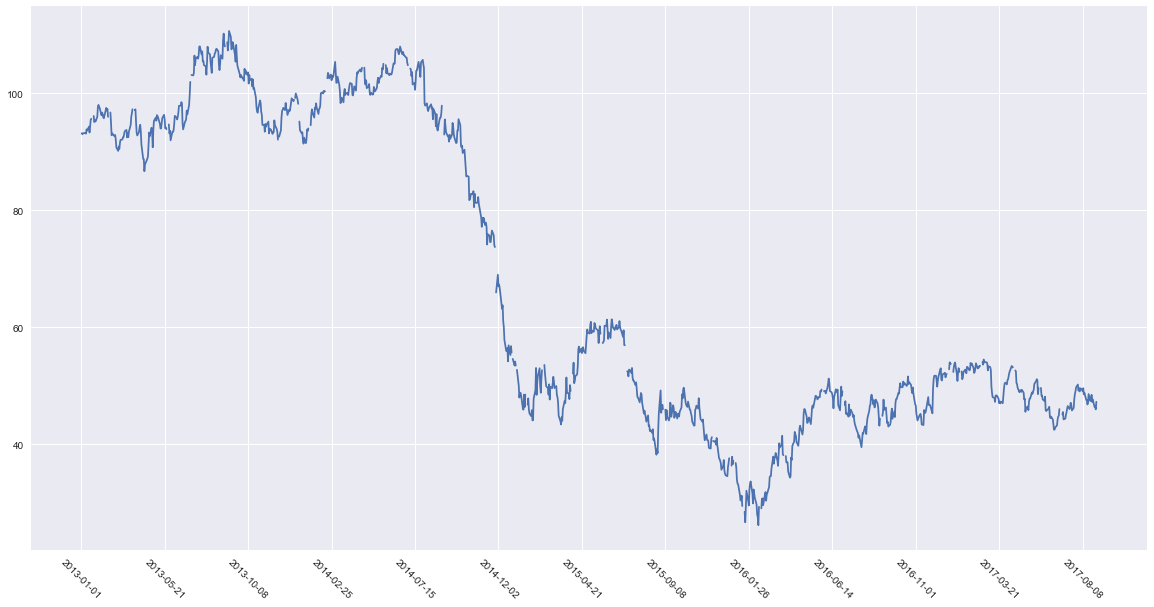

In [141]:
import matplotlib.ticker as tick
from matplotlib.ticker import FormatStrFormatter
from datetime import datetime, timedelta


def x_fmt(value, position):
    return (datetime.min + timedelta(days=value-1)).strftime('%Y-%m-%d')
    
majorFormatter = FormatStrFormatter('%Y%m%d')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

plt.plot(np.array(oil['dt']), oil['dcoilwtico'])

# 设置xticks的格式
tick_values = np.array(oil['date'][np.arange(1300, step=100)])
ticks = ax.set_xticks(tick_values)
ax.xaxis.set_major_formatter(tick.FuncFormatter(x_fmt))
plt.xticks(rotation=315)

# ax.xaxis_date()

In [118]:
ax.get_xaxis().get_major_formatter()

In [106]:
ax.xaxis.get_major_ticks()

### 商家交易

In [9]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### 商品信息

In [14]:
%%time
items.head()

Wall time: 2 ms


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


### 商家信息

In [11]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## 方案一
单模型 + 特征工程